## PRÁCTICA 2: Sistemas de Recomendación
# **Roberto Hernández Ruiz**

En esta práctica utilizaremos una librería en Python que implementa diversos algoritmos de factorización de matrices para su utilización en sistemas de recomendación


# 1) CONFIGURACIÓN DEL ENTORNO
Lo primero es instalar el paquete [***implicit***](https://implicit.readthedocs.io/en/latest/quickstart.html) en Python3.
En esta plataforma se instala con el comando:

`!pip install implicit==0.4.0`

**Nota**: Se instala la versión 0.4.0, ya que las versiones 0.4.1 y 0.4.2 tienen un bug en el algoritmo BayesianPersonalizedRanking

Si se desea instalar en Anaconda, sería con el siguiente comando:

`conda install -c conda-forge implicit`

In [ ]:
! pip install implicit==0.4.4

Instalamos las librerias estandar de Python *time* para calcular tiempos de ejecucióón, *numpy* para manipulación de matrices y *tqdm* para presentación genérica.

In [ ]:
import time
import numpy as np
import pandas as pd
import tqdm

De la librería *implicit* importamos las implementaciones de los algoritmos que nos interesan:


1.   ALS: AlternatingLeastSquares
2.   BPR: BayesianPersonalizedRanking
2.   LMF: LogisticMatrixFactorization

Y 3 algoritmos basados en el cálculo de distancias entre selecciones:


1.   BM25Recomender
2.   CosineRecommender: Selección de los más parecidos debida a su distancia coseno
1.   TFIDFRecomender: Selección basada en la distancia Term Frecuency - Inverse Document Frecuency


In [ ]:
from implicit.als import AlternatingLeastSquares
from implicit.bpr import BayesianPersonalizedRanking
from implicit.lmf import LogisticMatrixFactorization
from implicit.datasets.movielens import get_movielens
from implicit.nearest_neighbours import (BM25Recommender, CosineRecommender,
                                         TFIDFRecommender, bm25_weight)

# 2) Definición de funciones básicas:

Se define una función que dependiendo del algoritmo escogido (als, bpr, lmf, tfidf, cosine y bm25), instancia la clase que deseemos.

Parámetros de entrada:


*   Sigla del algoritmo a instanciar
*   Número de factores latentes en que queremos descomponer la matriz de preferencias. En caso de configurar para usar GPU, debe ser del tipo 32*N-1, con N entero positivo. Si no se escoge un número correctamente, el sistema redondea al siguiente número que cumpla esta norma.






In [ ]:
def get_model(model_name,num_factors):
  if model_name == "als":
      model = AlternatingLeastSquares(factors=num_factors)
      # lets weight these models by bm25weight.
  elif model_name == "bpr":
      model = BayesianPersonalizedRanking(factors=num_factors)  
  elif model_name == "lmf":
      model = LogisticMatrixFactorization(factors=num_factors)
  elif model_name == "tfidf":
      model = TFIDFRecommender()
  elif model_name == "cosine":
      model = CosineRecommender()

  elif model_name == "bm25":
      model = BM25Recommender(B=0.2)
  else:
      raise NotImplementedError("TODO: model %s" % model_name)
  return model

# 3) Selección de los datos y análisis
De la base de datos *movilens* hay disponibles varias versiones, variando el tamaño de número de películas evaluadas, y ratings. Los posibles valores son: 20m, 10m, 1m, 100k.

En la variable *variant* indicamos la versión con la que trabajaremos.

Inicialmente trabajaremos con la versión 100k, para observar los datos en crudo.

In [ ]:
variant='100k'
min_rating=4.0

In [ ]:
titles, ratings = get_movielens(variant)

Antes de realizar cualquier procesado, analice los datos de las variables titles y ratings. 



1.   Analice el tipo de datos que es la variable titles, número de elementos y tipo de contenido
2.   Analice el tipo de datos de la variable ratings: tipo de estructura, número de elementos que representa. Observe que es una matriz sparse. 
1.   Convierta la  ratings a una matriz normal (esto se puede hacer solo en el caso de la base de datos 100k), e interprétela: que representan las filas, las columnas, como se relacionan con el vector titles. Tambien observe la presencia de 0 en toda la matriz
2.   Calcule el usuario que más evaluaciones ha realizado, y el que más evaluaciones superiores a *min_rating* ha realizado. **Sugerencia:** busque las posiciones con un valor > 0 para el primer caso, y > *min_rating* para el segundo, indexando con esa matriz, sustituya los valores por 1 para los verdaderos y 0 para los falsos. Después sume por fila o columna los 1, y busque los que mayor número de evaluaciones tiene.
1.   Repita el proceso, y busque la película más evaluada por todos los usuarios, y con más evaluaciones superiores a *min_rating*. 




**TRUCOS**

Copie la matriz de ratings (para evitar corromperla) con el método Matriz.copy()

La variable ratings es de tipo matriz sparse. Cuando una matriz tiene más de la mitad de los datos en 0, es mejor codificarlo en este tipo de estructuras. Lo que se almacenan son tuplas del tipo (fila,columna,valor) para aquellas posiciones cuyo valor es diferente de 0.

La matriz de ratings es una matriz comprimida por filas: tiene las N filas originales, cada una de ellas con un listado de columna, valor paralas posiciones distintas de 0.

La matriz ratings tiene por fila el id de la película y en las columnas la valoración de los usuarios.

* Para ver que métodos posee un objeto, se puede listar con la función dir(*objeto*)

* En el caso de una matriz_csr, los datos, independientes de su posición en la matriz, están accesibles vía la propiedad *data*

* Para convertir una matriz sparse a una matriz normal, en numpy, se utiliza el método toarray()

* Si se desea conocer las dimensiones de una matriz, se puede utilizar la propiedad *shape* (ratings.shape), y devuelve filas vs. columnas.

* Se pueden realizar comparaciones booleanas para manipular las matrices:

> Si deseo buscar las posiciones cuyo valor son superiores a 3, puedo realizar la siguiente operación:
```
Mratings=ratings.toarray()
Upper3 = Mratings>3
```

> La matriz Upper3 (de tipo boolean), indica *true* en las posiciones en las que los valores son mayores a 3.

* La operación de numpy  [np.sum(Matriz,axis=0)](https://docs.scipy.org/doc/numpy/reference/generated/numpy.sum.html) suma los elementos por columna, devolviendo un vector de N posiciones (N columnas). Para más información de [Numpy](https://docs.scipy.org/doc/numpy)

* Para negar la matriz, use la funcion de numpy np.logical_not(Matriz) 

In [ ]:
print("La variable titles es de tipo",type(titles),"y contiene",len(titles),"elementos de clase",titles.dtype, ".")
print("La variable ratings es de tipo",type(ratings),", tamaño",ratings.shape,"y con elementos de tipo",ratings.dtype)
#print(ratings)

# A matriz: las filas son las 1683 peliculas, y las columnas los 944 usuarios que valoran (o no) cada pelicula
rat = ratings.copy()
rat = rat.toarray()
#print(rat) 

evals = np.sum(rat > 0, axis=0)
evalsmin = np.sum(rat > min_rating, axis=0)
print("El user que más ha valorado es", np.where(evals == evals.max()), "con", max(evals), "valoraciones.")
print("El que más ha valorado sobre la minima es",np.where(evalsmin==evalsmin.max()),"con",max(evalsmin),"valoraciones.")
pelis = np.sum(rat > 0, axis=1)
pelismin = np.sum(rat > min_rating, axis=1)
print("La pelicula más valorada es",np.where(pelis==pelis.max()),"con",max(pelis),"valoraciones.")
print("La pelicula más valorada sobre la mínima es",np.where(pelismin==pelismin.max()),"con",max(pelismin),"valoraciones.")


## 3.1) ADAPTACIÓN DE LOS DATOS A LA LIBRERÍA IMPLICIT

Los algoritmos implementados asumen que aquellas evaluaciones por debajo de un nivel mínimo, son evaluaciones negativas. 

La matriz de factores latentes se calcula a partir de si hay evaluación positiva (1) o negativa (0). Por lo que hay que adaptar la matriz de ratings a estas características.

A diferencia del apartado anterior, modificamos directamente la matriz sparse ratings, en su propiedad "data".

In [ ]:
# Mejor volvemos a cargar los datos, y ya podemos escoger la BBDD de mayor tamaño...
variant='100k'
min_rating=4.0

In [ ]:
titles, ratings = get_movielens(variant)

In [ ]:
ratings.data[ratings.data < min_rating] = 0
ratings.eliminate_zeros()
ratings.data = np.ones(len(ratings.data))

# 4) Definición del modelo, instanciación y adaptación de los datos en caso de ALS.

In [ ]:
model_name='als'

In [ ]:
num_factors=32

In [ ]:
model = get_model(model_name,num_factors)

In [ ]:
if model_name == "als" :
  ratings_W = (bm25_weight(ratings, B=0.9) * 5).tocsr()
else:
  ratings_W = ratings

Una vez instanciado el modelo con base en el algoritmo que deseamos, es hora de entrenarlo, con el método fit()

In [ ]:
start = time.time()
model.fit(ratings_W,show_progress=True)
print ("Modelo entrenado {0} en {1} seg".format(model_name,time.time()-start))

## 4.1) Análisis de resultados:

Para analizar los resultados podemos utilizar:
* model.similar_items(item_id,N): Extrae los N items más similares al item item_id.
* model.similar_users(user_id,N): Extrae los N usuarios más próximos por preferencias al usuarios user_id.
* model.recommend(user_id,ratings.T,N=Num_items,filter_already_liked_items=False): calcula las recomendaciones para el usuario *user_id*, con base en el modelo entrenado y una matriz de usuarios vs evaluaciones, presentando las N primeras recomendaciones, su identificador y su grado de proximidad.


Seleccione una pelicula y un usuario, y extraiga, usando los respectivos métodos, los 20 elementos más proximos.

Con base en los títulos de las películas, analice la coherencia de las recomendaciones.

In [ ]:
# De la pelicula 100, extraer las 20 mas parecidas
model.similar_items(100,20)

In [ ]:
# Del usuario 40, extraer los 20 mas parecidos segun las preferencias
model.similar_users(40,20)

## 4.2) Análisis de resultados: Gráficas de precisión y recuperación:

Las gráficas de precisión y recuperación sirven para calcular el púnto óptimo de corte de un listado de sugerencias.

Dado que conocemos el vector de preferencias de un usuario (en este caso, el vector de películas a las que un usuario ha calificado con *min_rating* o más) y el sistema nos ha ofrecido N sugerencias:

* El valor de **precisión** de esas N sugerencias es el porcentaje de aciertos de las sugerencias,i.e: cuantas de las sugerencias han sido realmente evaluadas con *min_rating* o más por el usuario, dividido por N.

* El valor de **recuperación** corresponde a la relación entre el número de sugerencias acertadas, dividida por el número total de películas que el usuario ha valorado positivamente.

Un código para calcular la precisión y recuperación para las N=24 primeras sugerencias del modelo del usuario=15 puede ser el que sigue:





###4.2.1) Ejemplo de cálculo de precisión y recuperación para el usuario 15, y las 24 primeras sugerencias

In [ ]:
usuario=15

In [ ]:
recomendations=model.recommend(usuario,ratings_W.T,N=50,filter_already_liked_items=False) #Aqui se calculan las 50 primeras recomendaciones del sistema

In [ ]:
recomendations

In [ ]:
user_selections=ratings[:,usuario].toarray() #Aqui se extraen de la matriz ratings las evaluaciones del usuario 15

In [ ]:
num_positivas=np.sum(user_selections) #teniendo en cuenta que la matris ratings solo tiene 1 y 0, sumamos todos los valores para saber el número de valoraciones positivas del usuario 15

In [ ]:
print("El número de películas que le gustaron al usuario {0} fueron: {1}".format(usuario,int(num_positivas)))

In [ ]:
items=list(map(lambda x: x[0], recomendations)) # De las recomendaciones provistas por el modelo, obtenemos la lista de items recomendados
similarity=list(map(lambda x: x[1], recomendations)) # De las recomendaciones provistas por el modelo, obtenemos la lista de proximidad de los items recomendados 

In [ ]:
N=24 #Vamos a evaluar las primeras N=24 recomendaciones

In [ ]:
sub_items=items[:N] # Obtenemos las 24 primeras recomendaciones

In [ ]:
print(sub_items)

In [ ]:
print(titles[sub_items])

In [ ]:
seleccion=user_selections[sub_items] #Del vector de evaluaciones, extraemos las evaluaciones para las posiciones de las recomendaciones realizadas. Observe que no todas son 1.

In [ ]:
print(seleccion.T)

In [ ]:
acertados=np.sum(seleccion) #Del vector de seleccion, calculamos el número de aciertos, es decir: el número items recomendados que realmente fueron bien evaluados por el usuario 24

In [ ]:
precision=acertados/N #Calculamos la precisión de la recomendación: numero de aciertos, sobre el número de recomendaciones

In [ ]:
recall=acertados/num_positivas #Calculamos el nivel de recuperación. es decir el número de aciertos con respecto al número de evaluaciones positivas

In [ ]:
print("La precisión del modelo entrenado para el usuario {0}, en los {1} primeros elementos es: {2}".format(usuario,N,precision))

In [ ]:
print("La recuperación del modelo entrenado para el usuario {0}, en los {1} primeros elementos es: {2}".format(usuario,N,recall))

#5) CÁLCULO DE PRECISION Y RECUPERACIÓN

Desarrollen las funciones *calcular_precison* y *calcular_recuperacion* basándose en el código anterior

In [ ]:
def calcular_precision(user_ratings,model_recomendations):
  #El vector precision es un vector de longitud el número de recomendaciones realizadas.
  #Debe almacenar en cada posicion K del vector precision el valor de la precisión si se toman los K primeros elementos
  num_datos=len(model_recomendations)
  precision=np.zeros(num_datos)
  
  for i in range(num_datos):
    sub_items=model_recomendations[:(i+1)]
    num_aciertos=np.sum(user_ratings[sub_items])
    # Calculamos la precision para cada caso e iteramos
    precision[i]=num_aciertos/(i+1)
    print("Iteración",i+1,": precisión",precision[i],"y",int(num_aciertos),"aciertos.")

  return precision

In [ ]:
def calcular_recuperacion(user_ratings,model_recomendations):
  num_datos=len(model_recomendations)
  recuperacion=np.zeros(num_datos)

  for i in range(num_datos):
    sub_items=model_recomendations[:(i+1)]
    num_aciertos=np.sum(user_ratings[sub_items])
    num_preferidas=np.sum(user_ratings)
    # Calculamos la recuperacion para cada caso e iteramos
    recuperacion[i]=num_aciertos/num_preferidas
    print("Iteración",i+1,": recuperación",recuperacion[i])

  return recuperacion

In [ ]:
user_id=20 #USUARIO

In [ ]:
N=80 #Numero de recomendaciones

In [ ]:
user_selections=ratings[:,usuario].toarray() 

In [ ]:
recomendations=model.recommend(user_id,ratings_W.T,N=N,filter_already_liked_items=False)

In [ ]:
items=list(map(lambda x: x[0], recomendations)) # De las recomendaciones provistas por el modelo, obtenemos la lista de items recomendados
similarity=list(map(lambda x: x[1], recomendations)) # De las recomendaciones provistas por el modelo, obtenemos la lista de proximidad de los items recomendados 

In [ ]:
precision = calcular_precision(user_selections,items)

In [ ]:
recuperacion = calcular_recuperacion(user_selections,items)

In [ ]:
from matplotlib import pyplot as plt
import sys

plt.plot(range(N), precision, 'r-',range(N),recuperacion,'g-')

plt.title("Precisión vs recuperación")
plt.xlabel('Número de elementos')
plt.legend(['Precisión','Recuperación'])
plt.show()

### Interpretación de la gráfica:
El punto de intersección entre las curvas de precisión y recuperación, indica el punto de evaluación óptimo para cortar las recomendaciones.

En la gráfica se observa la precisión y la recuperación. 
Conforme se avanza e incrementando el número de elementos, **la precisión** (número de aciertos sobre el número de recomendaciones) **va disminuyendo progresivamente** (el sistema cada vez recomienda menos películas que el usuario haya escogido), y **a la vez la recuperación** (número de aciertos sobre las evaluaciones positivas del usuario) **va incrementándose**. El punto aproximado de intersección entre ambas gráficas indica el número de elementos concreto en el que deberían cortarse las recomendaciones al usuario.

# Fase final

Recalcule el modelo con un número de factores superior (64,128,160) y compare los resultados de precisión y recuperación.

Adicionalmente cambie el modelo a bpr y lmf, y compare los resultados.

**Para nuestro ejemplo de valoración del usuario 20 y con N=80 recomendaciones**, cambiando el número de factores en el propio código obtenemos diferentes resultados en la evolución de las gráficas de precisión y recuperación, como se muestra en las siguientes capturas de pantalla de las gráficas para el modelo ALS con 32, 64, 128 y 160 factores, respectivamente. En todos los casos para nuestro ejemplo el punto de intersección de la precisión y la recuperación, donde deberíamos detener las recomendaciones, es alrededor de los 40 elementos.

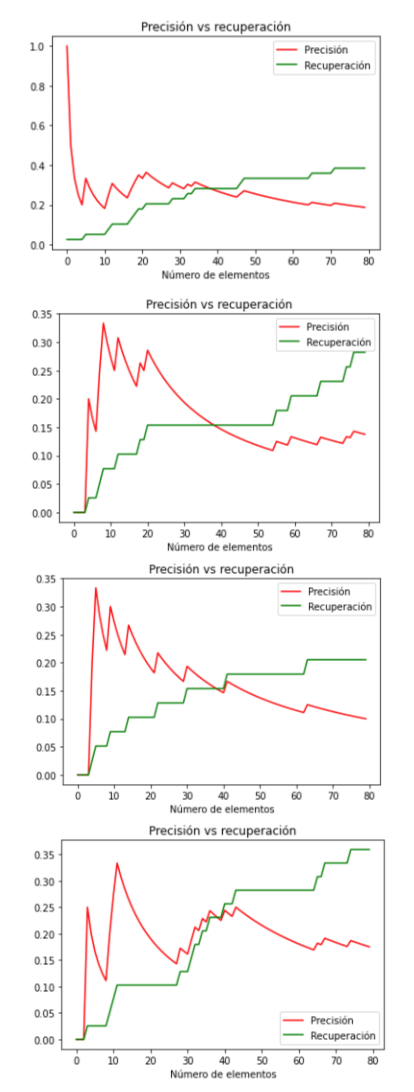

**Adicionalmente también se ha cambiado el modelo a BPR y LMF**. Con 32 factores se han obtenido las siguientes gráficas de precisión y recuperación en el mismo caso de ejemplo que se analiza todo el rato, esto es, usuario número 20 con 80 recomendaciones.

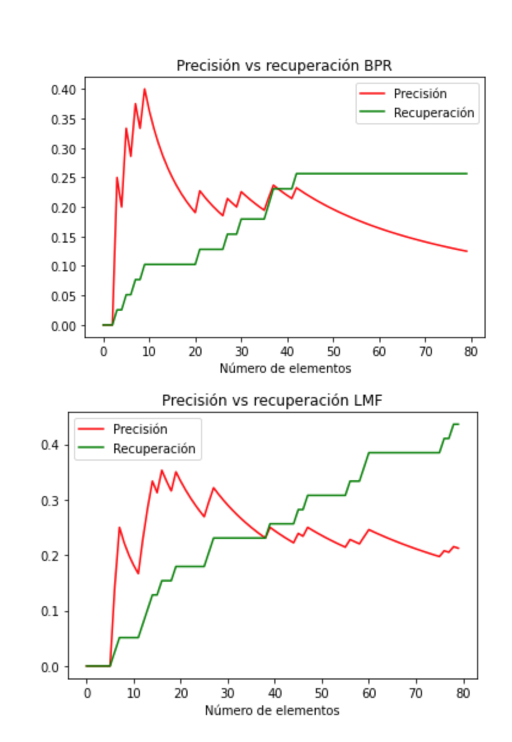